In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
CATEGORICAL_FEATURES = [
    "product_type",
    "dish_type",
    "protein_cuts",
    "heat_level",
    "difficulty",
    "preferences",
]
NUMERICAL_FEATURES = [
    "proteins",
    "number_of_ingredients_per_recipe",
    "fat",
    "carbs",
    "calories",
    "n_products",
]
TEXT_FEATURES = [
    "recipe_name",
]
TAGS_FEATURES = [
    "meta_tags",
    "carbs_content",
    "dish_types",
]

CATEGORICAL_FEATURES = CATEGORICAL_FEATURES + ['cuisine', 'cooking_time', 'protein_types', 'seasons'] + TAGS_FEATURES


In [3]:
pd.set_option('display.max_columns', None)
df_train_clean = pd.read_csv('../data/train_data_cleaned.csv')
df_test_clean = pd.read_csv('../data/test_data_cleaned.csv')

In [4]:
def get_unique_values(df, column):
    column_values = df[[column]].values.ravel()
    unique_values = pd.unique(column_values)
    return unique_values


def bar_plot(df, column, title):
    grouped_df = df.set_index("year_week").groupby(column).sales.sum().reset_index().sort_values('sales', ascending = False)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
    ax = sns.barplot(x=grouped_df[column], y=grouped_df.sales, palette="pastel")
    ax.set_title(title.upper(), fontsize=20)
    ax.tick_params(labelsize=20)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


def box_plot(df, title):
    plt.figure(figsize = (25,10))
    sns.boxplot(x = 'variable', 
                y = 'value', 
                data =df.melt()).set_title(title.upper())


def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

def ordinal_encoder(df, features):
    encoder = OrdinalEncoder(handle_missing="return_nan")
    encoded_df = encoder.fit_transform(df[features].fillna("UNK").astype(str))
    return encoded_df

In [5]:
missing_values_table(df_train_clean)

Your selected dataframe has 27 columns.
There are 20 columns that have missing values.


,Missing Values,% of Total Values
cooking_tip,2939,100.0
protein_cuts,991,33.7
seasons,925,31.5
meta_tags,870,29.6
cuisine,833,28.3
heat_level,716,24.4
dish_types,704,24.0
course_type,703,23.9
protein_types,701,23.9
carbs_content,701,23.9


In [6]:
df_train_clean.describe(include="all").T.sort_values("top")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_type,2939,4,2 person,1339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recipe_name,2939,931,AFC Braised Black Bean Stew,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_classic,2939,1,No,2939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,2935,980,Pad Thai is one of our favorite street foods t...,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seasons,2014,10,all_seasons,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
difficulty,2930,1,easy,2930,NaN,NaN,NaN,NaN,NaN,NaN,NaN
course_type,2236,1,main,2236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dish_type,2521,4,meat,1411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dish_types,2235,108,meat_and_side,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cuisine,2106,27,new_american,897,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_train_clean_copy = df_train_clean.copy()
df_train_clean_copy['cuisine'] = df_train_clean_copy['cuisine'].fillna('other')
df_train_clean_copy['cooking_time'] = df_train_clean_copy['cooking_time'].fillna('undefined')
df_train_clean_copy['protein_types'] = df_train_clean_copy['protein_types'].fillna('unknown')
df_train_clean_copy['seasons'] = df_train_clean_copy['seasons'].fillna('unknown')

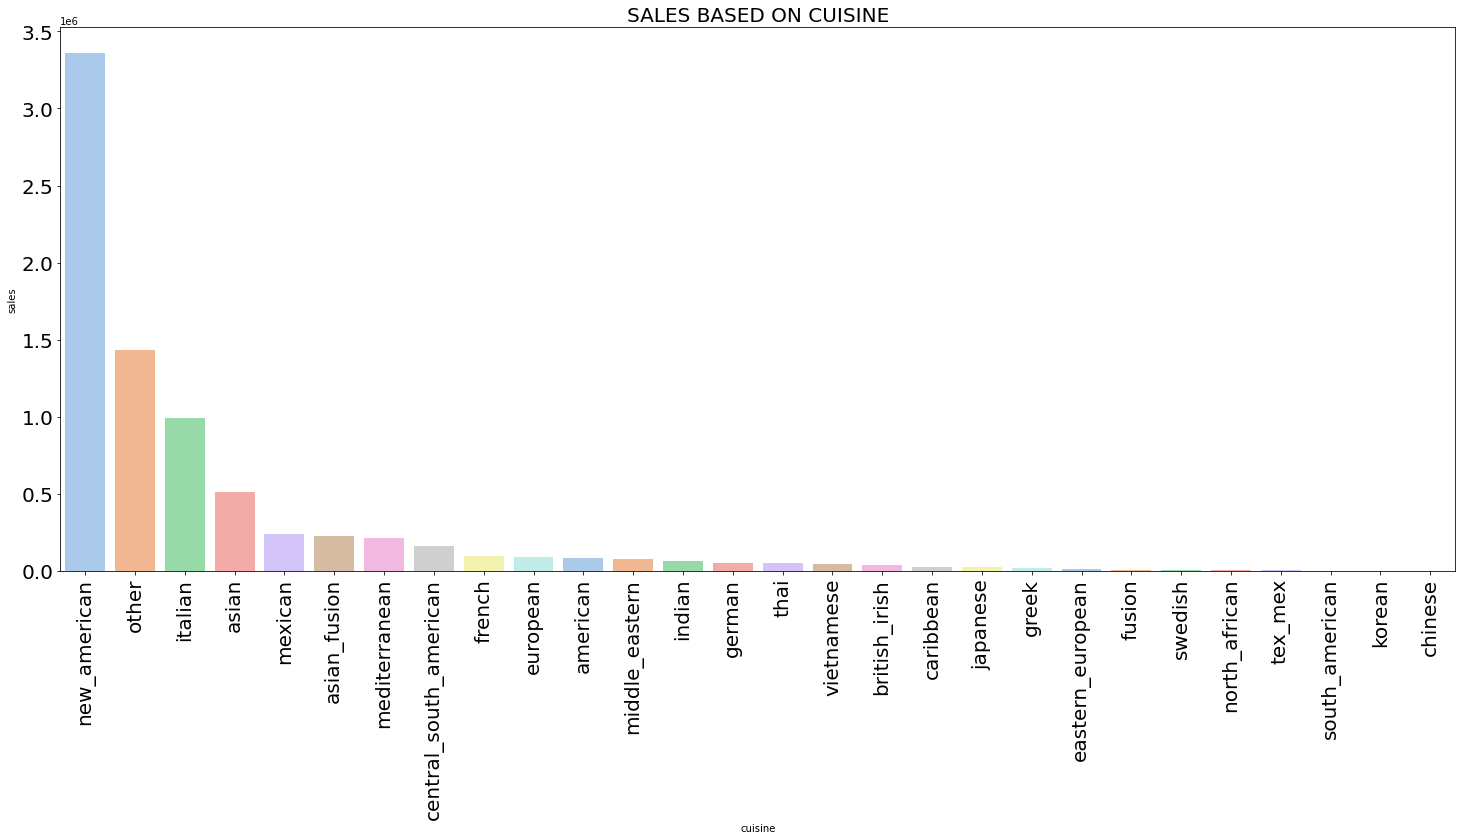

In [8]:
bar_plot(df_train_clean_copy, 'cuisine', 'Sales based on cuisine'.upper())

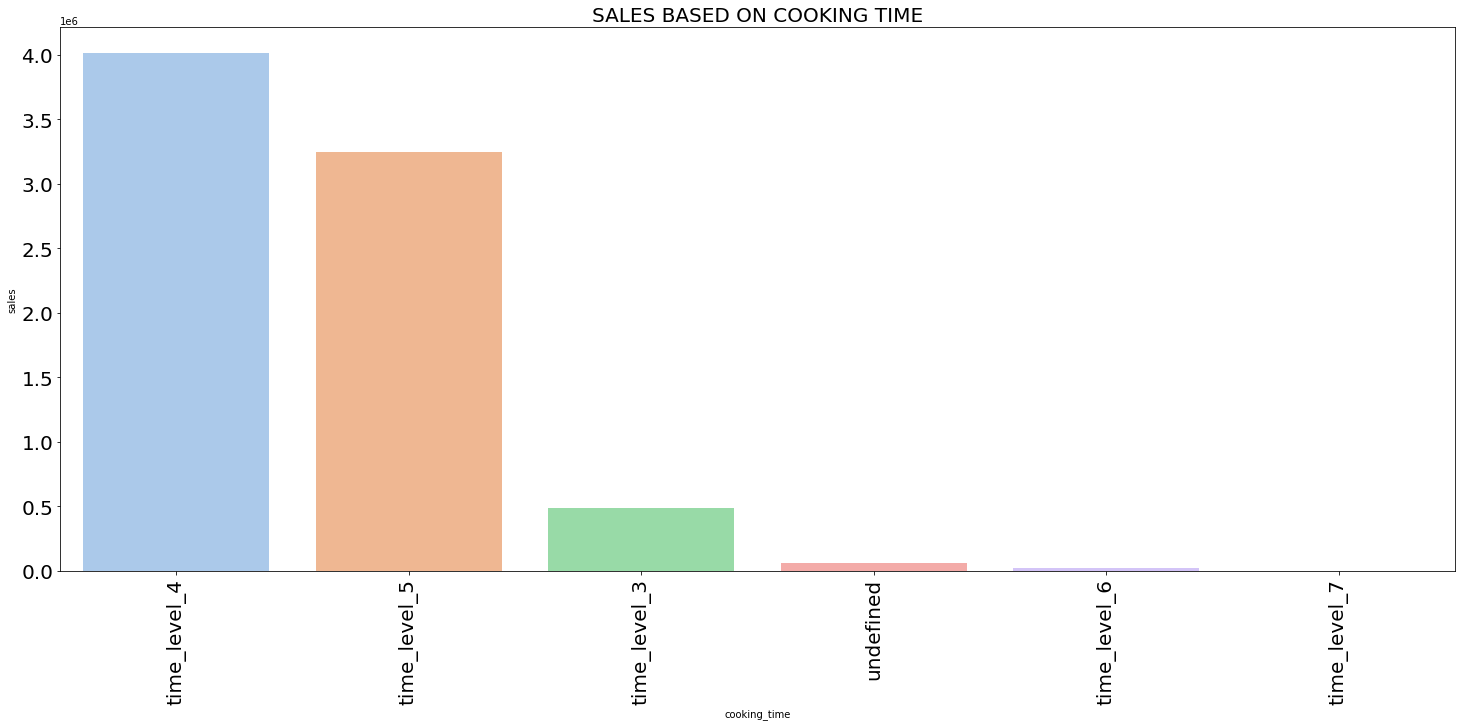

In [9]:
bar_plot(df_train_clean_copy, "cooking_time", 'Sales based on cooking time'.upper())

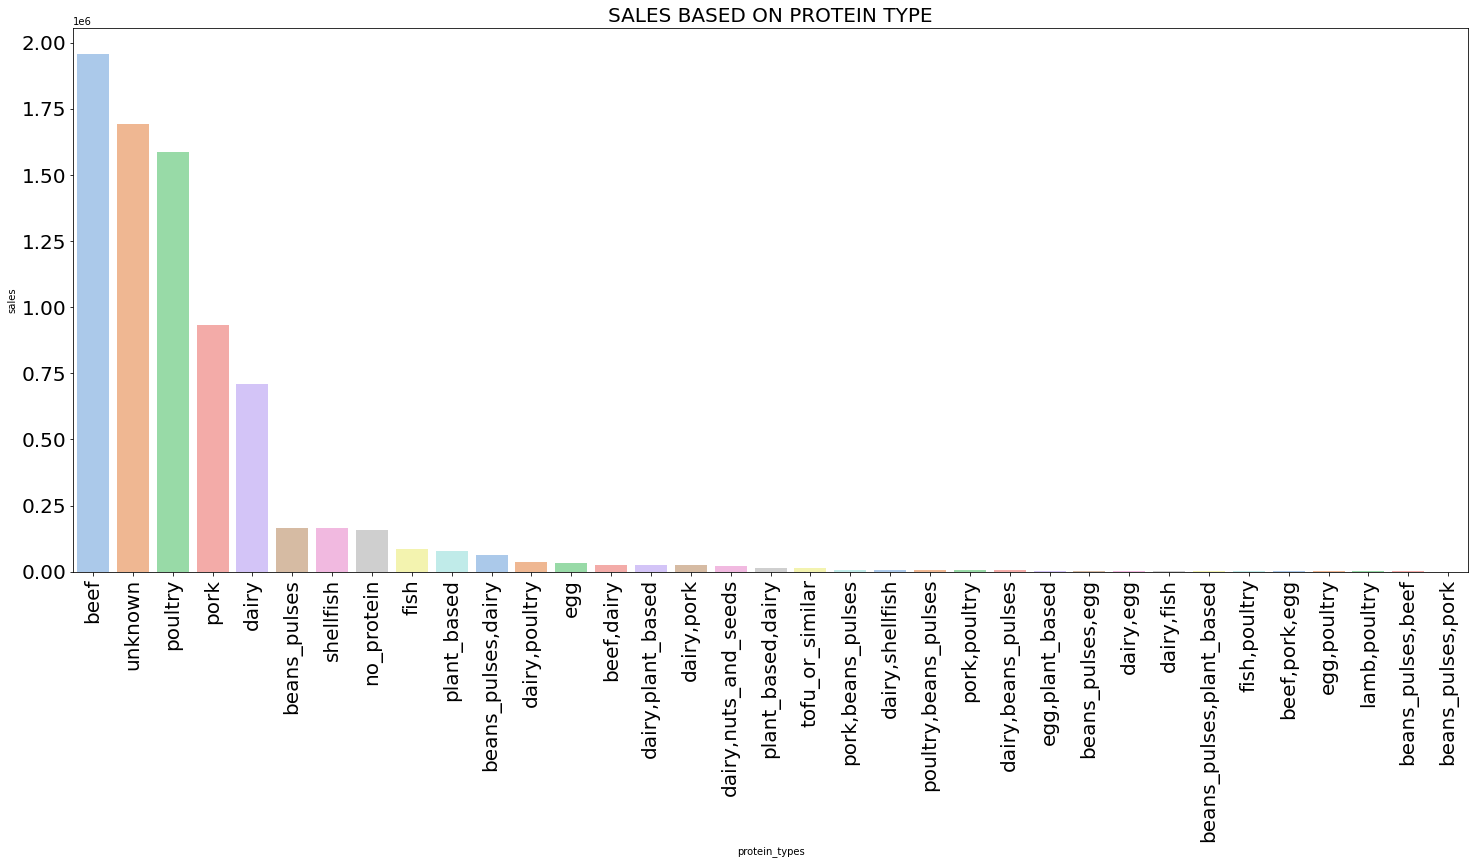

In [10]:
bar_plot(df_train_clean_copy, "protein_types", 'Sales based on protein type'.upper())

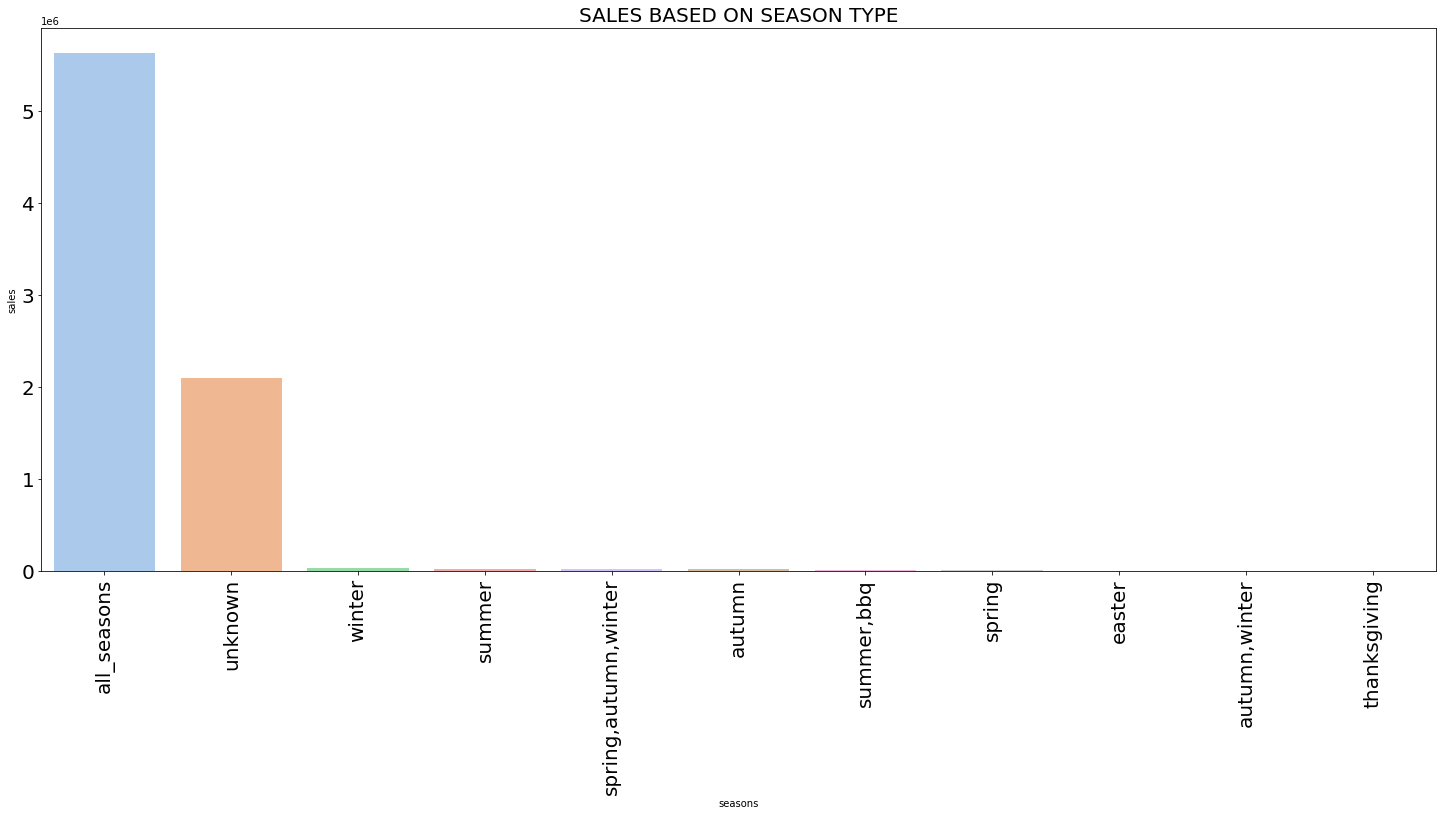

In [11]:
bar_plot(df_train_clean_copy, "seasons", 'Sales based on season type'.upper())

In [12]:
categorical_features_df = ordinal_encoder(df_train_clean_copy, CATEGORICAL_FEATURES)

Feature 0: product_type, Score: 0.26549
Feature 1: dish_type, Score: 0.09474
Feature 2: protein_cuts, Score: 0.15572
Feature 3: heat_level, Score: 0.03149
Feature 4: difficulty, Score: 0.00000
Feature 5: preferences, Score: 0.03404
Feature 6: cuisine, Score: 0.07244
Feature 7: cooking_time, Score: 0.04229
Feature 8: protein_types, Score: 0.01560
Feature 9: seasons, Score: 0.01675
Feature 10: meta_tags, Score: 0.09247
Feature 11: carbs_content, Score: 0.08533
Feature 12: dish_types, Score: 0.09364


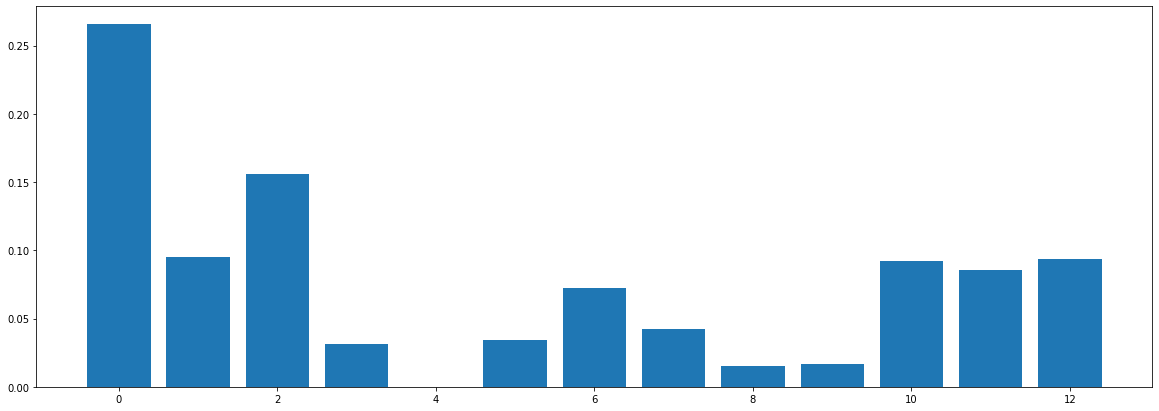

In [13]:
model = DecisionTreeRegressor()
model.fit(categorical_features_df, df_train_clean_copy.sales)
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature %0d: %s, Score: %.5f' % (i, CATEGORICAL_FEATURES[i],v))

rcParams['figure.figsize'] = 20, 7
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [14]:
numerical_data = df_train_clean_copy[["proteins",
                                      "number_of_ingredients_per_recipe",
                                      "fat",
                                      "carbs",
                                      "calories"]]

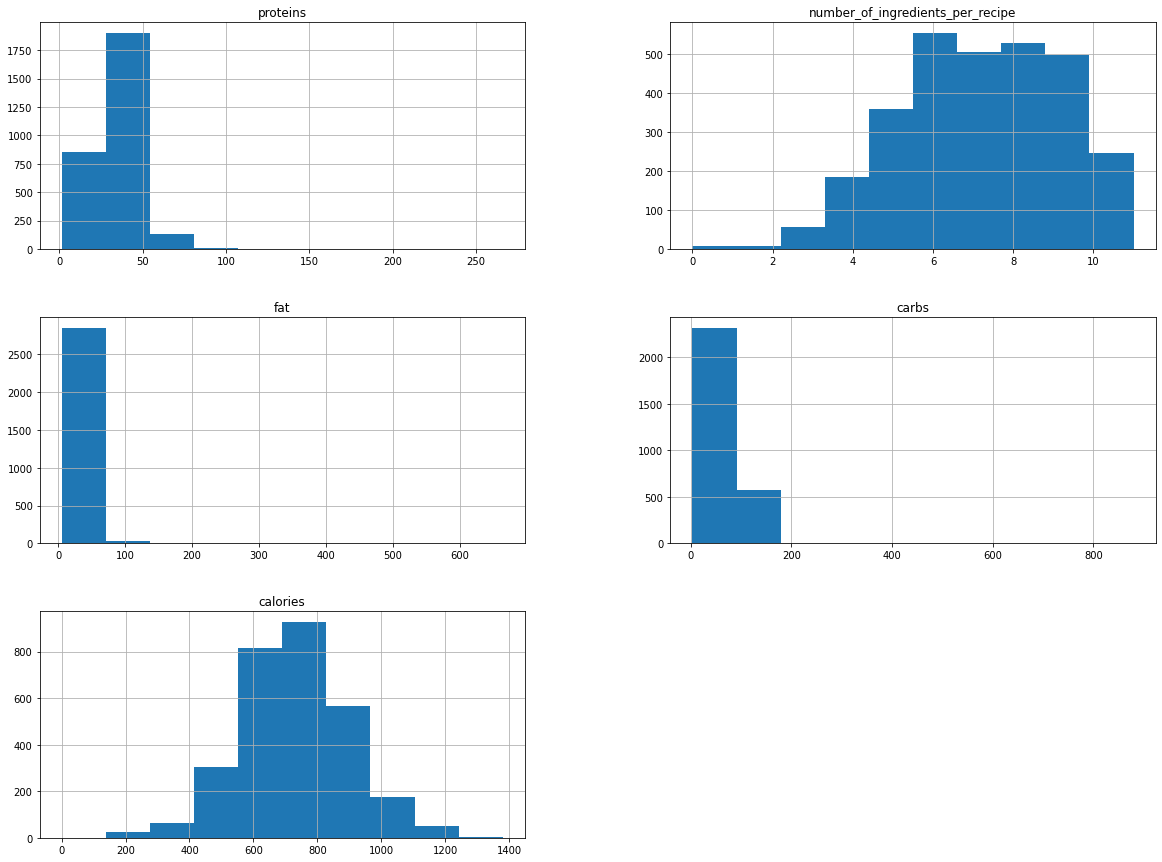

In [15]:
numerical_data.hist(figsize = (20, 15));

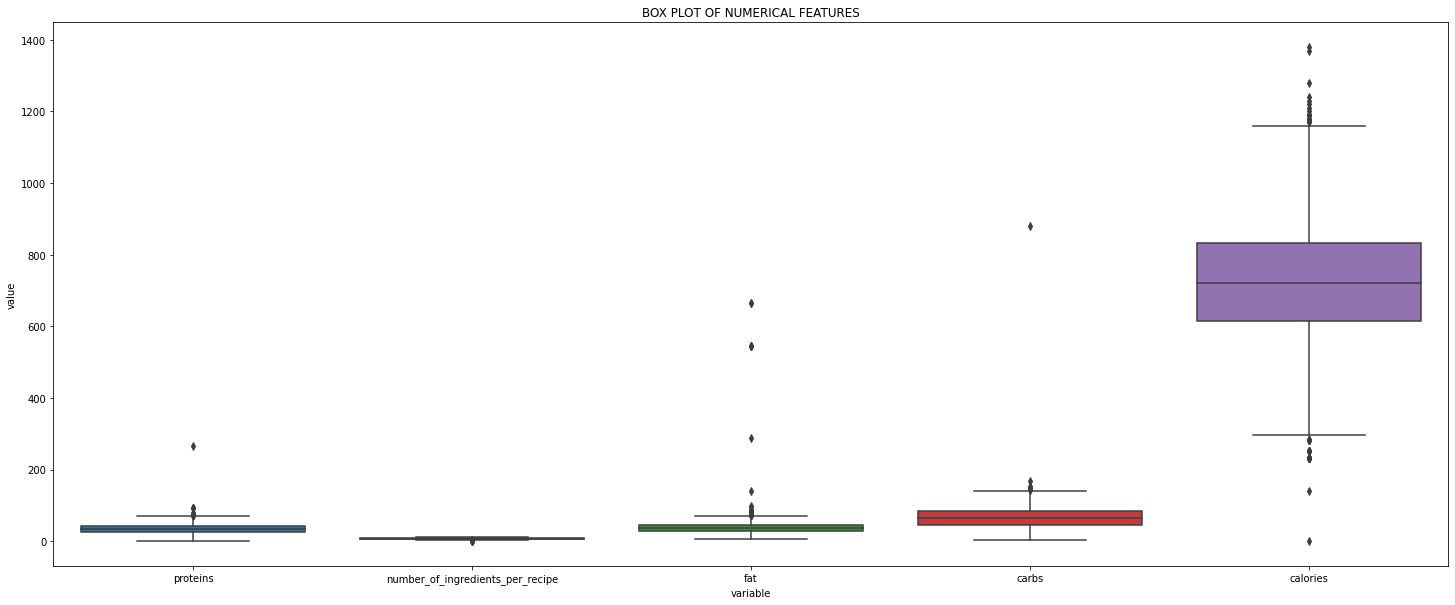

In [16]:
box_plot(numerical_data, 'box plot of numerical features')

In [17]:
df_train_analysis = df_train_clean.copy()

Text(0.5, 1.0, 'Rolling mean and rolling standard deviation plot')

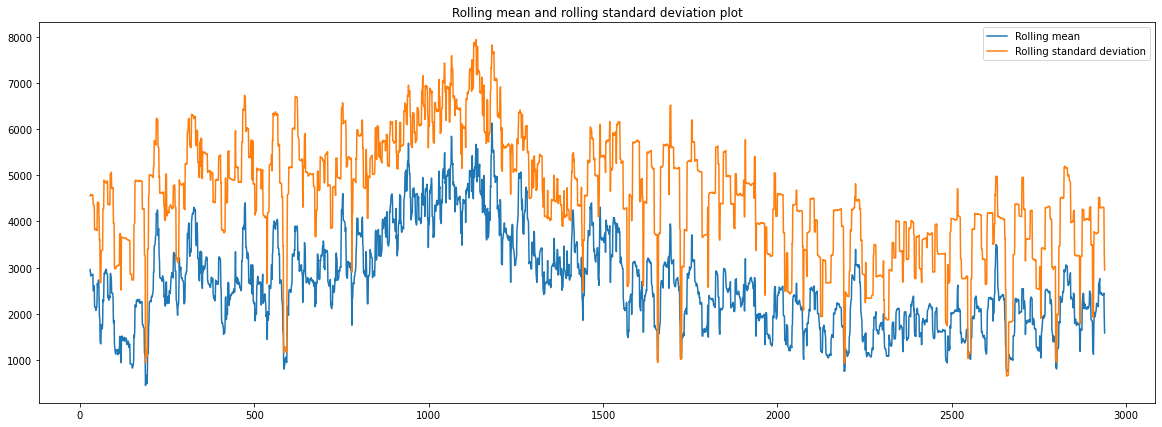

In [18]:
rcParams['figure.figsize'] = 20, 7
rolling_mean = df_train_analysis.sales.rolling(window=30).mean()
rolling_std = df_train_analysis.sales.rolling(window=30).std()
rolling_mean.plot()
rolling_std.plot()
plt.legend(['Rolling mean', 'Rolling standard deviation'])
plt.title('Rolling mean and rolling standard deviation plot')


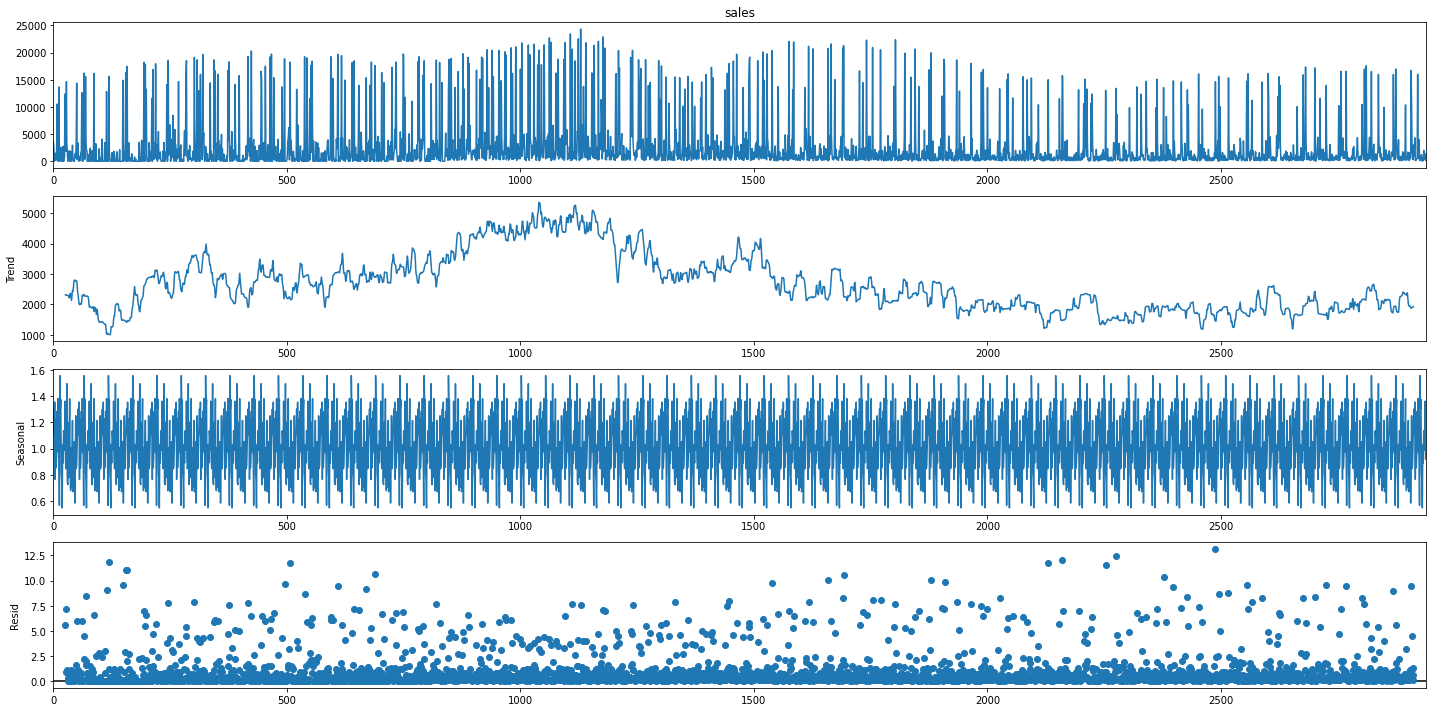

In [36]:
rcParams['figure.figsize'] = 20, 10
result = seasonal_decompose(df_train_analysis.sales, model='multiplicative', period=52)
result.plot()
plt.show()

<AxesSubplot:>

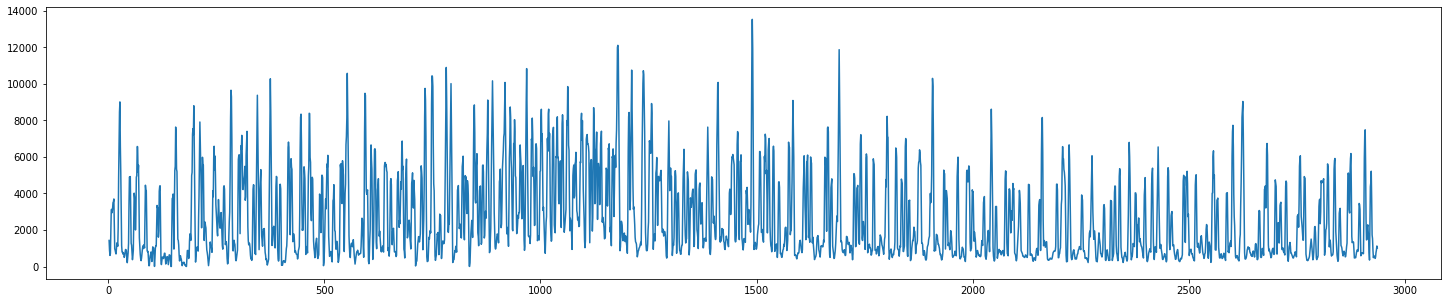

In [23]:
result.trend.plot(kind='line', use_index=True, figsize=(25,5))

<AxesSubplot:>

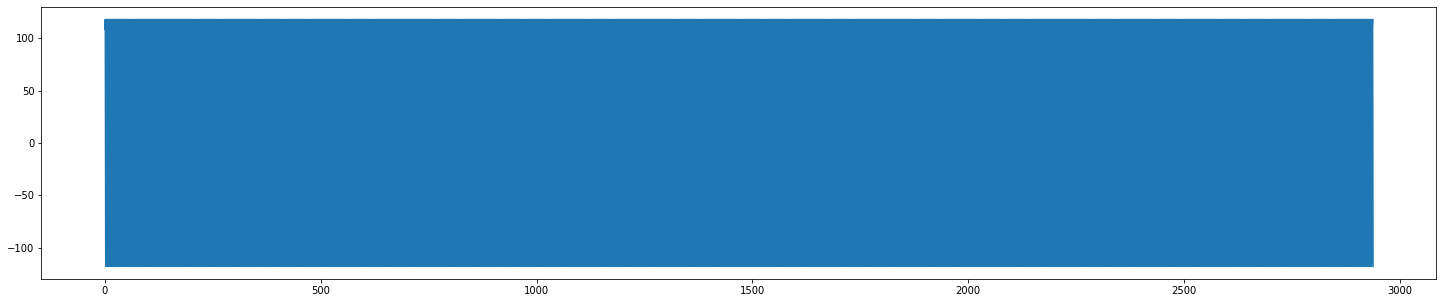

In [29]:
result.seasonal.plot(kind='line', use_index=True, figsize=(25,5))

<AxesSubplot:>

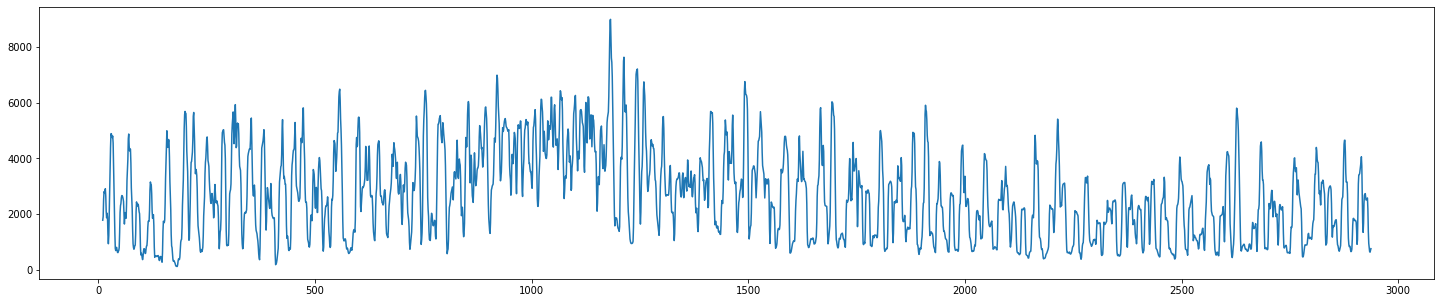

In [20]:
result.trend.rolling(window=10).mean().plot(kind='line', use_index=True, figsize=(25,5))

<AxesSubplot:>

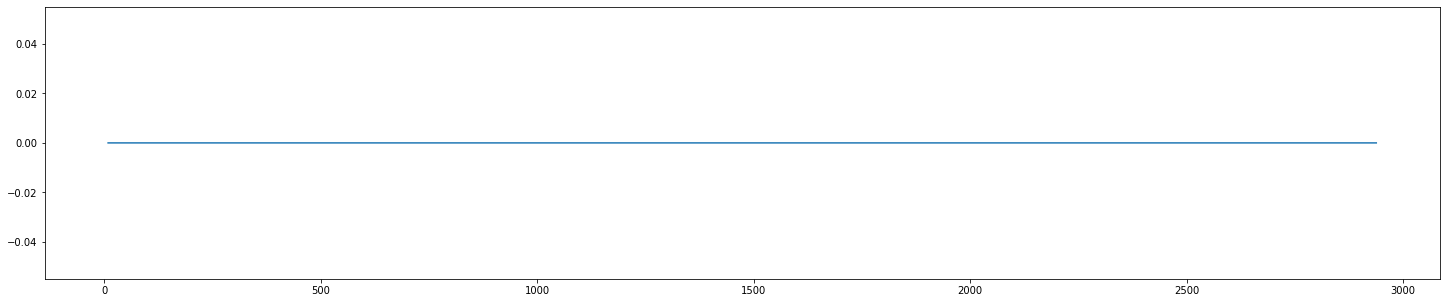

In [21]:
result.seasonal.rolling(window=10).mean().plot(kind='line', use_index=True, figsize=(25,5))

<AxesSubplot:>

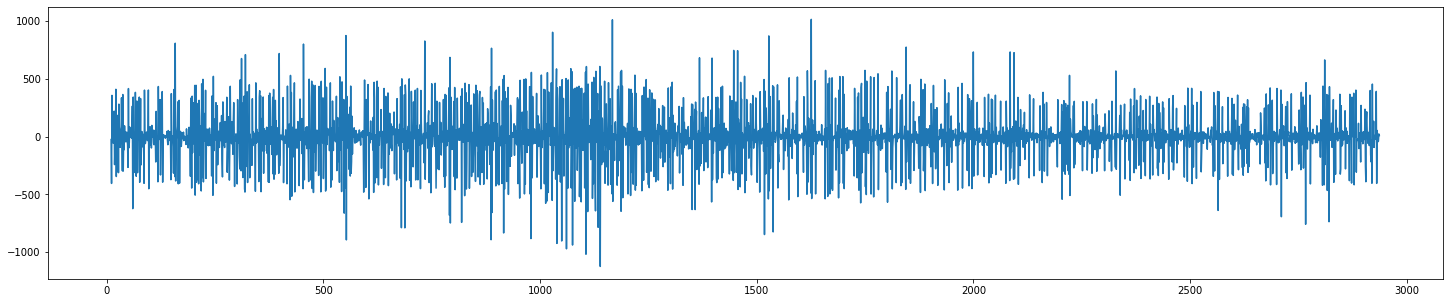

In [22]:
result.resid.rolling(window=10).mean().plot(kind='line', use_index=True, figsize=(25,5))

In [23]:
result = adfuller(df_train_analysis.sales, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -53.343091
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [37]:
lag_acf = acf(df_train_analysis.sales, nlags=52)
lag_pacf = pacf(df_train_analysis.sales, nlags=52, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

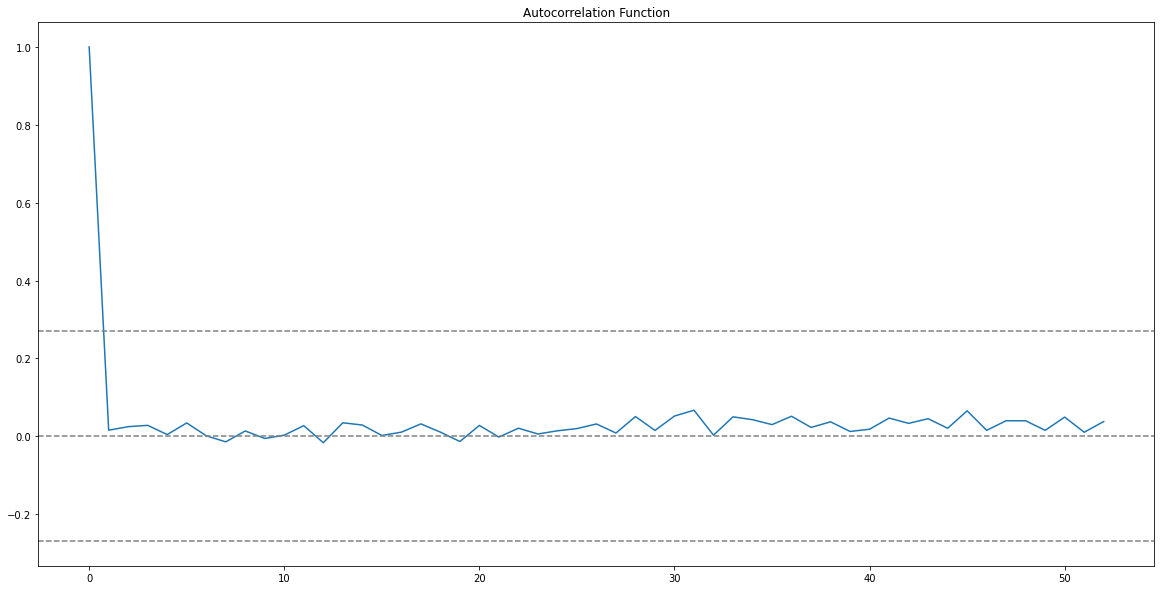

In [38]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

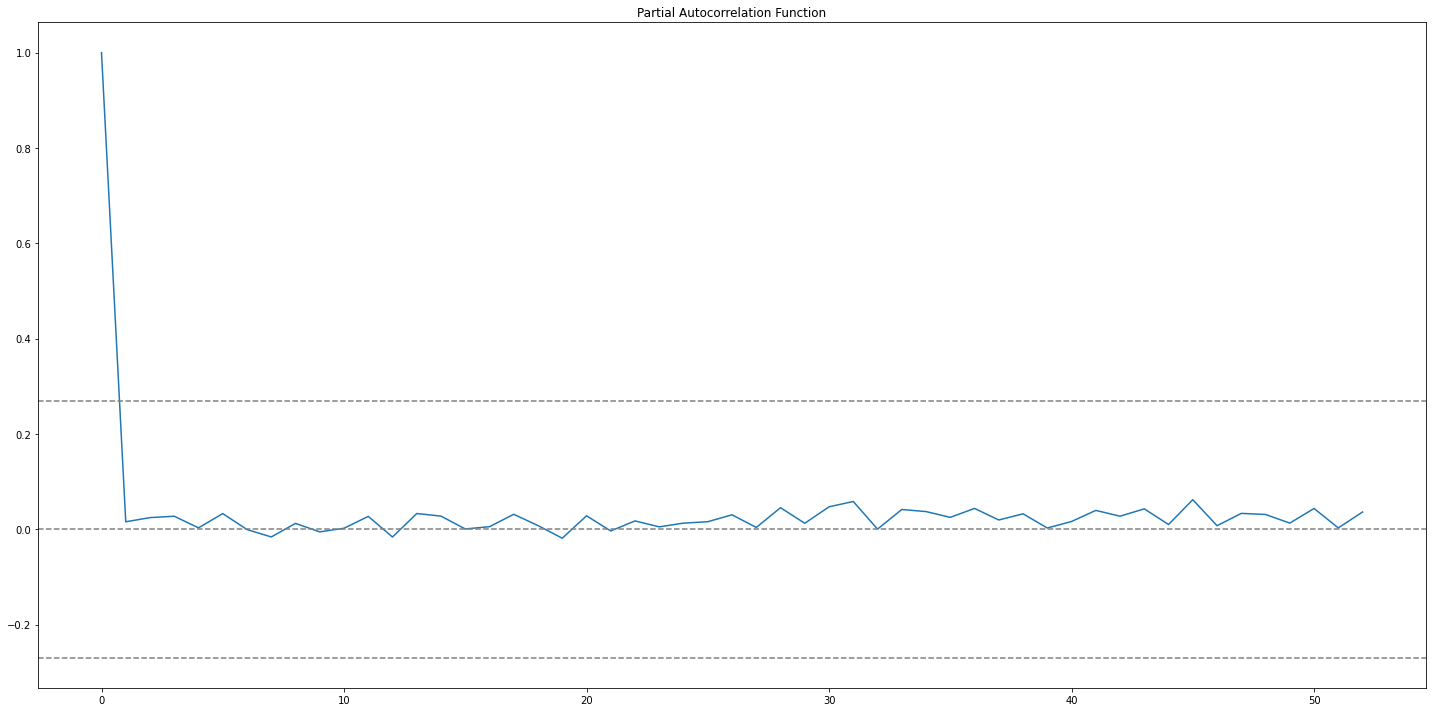

In [39]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
